In [66]:
import pandas as pd
import argparse
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
import os
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
from nilearn.image import math_img, load_img
group = "gangnam_total"
variable = "HADS_depression"
roi = "Temporal_Inf_L"
smoothness = 6
mdmr_dir = os.path.expanduser("~/fmri_project/C-PAC/CPAC/bcb_mdmr/")
nas_dir = os.path.expanduser("/mnt/NAS2-2/data/")
MDMR_output_dir = f"{nas_dir}/SAD_gangnam_MDMR/"
fmri_prep_dir = f"{nas_dir}/SAD_gangnam_resting_2/fMRIPrep_total"
seed_anal_dir = f"{nas_dir}/SAD_gangnam_seed_based_analysis/"

regressor_df = pd.read_csv(
    f"{mdmr_dir}/regressor/{group}_{variable}_regressor.csv"
)

subjects_label = regressor_df["Participant"].values
# 필요한 열만 선택하여 디자인 매트릭스 생성

extra_info_subjects = pd.DataFrame({
    "subject_label": subjects_label,
    variable: regressor_df[variable],
    "sex": regressor_df["SEX"],
    "age": regressor_df["AGE"],
    "yr_edu": regressor_df["YR_EDU"],
    "mean_framewise_displacement": regressor_df["Mean_Framewise_Displacement"]
})

# Create a StandardScaler object
scaler = StandardScaler()

# List of columns to normalize
columns_to_normalize = ["age", "yr_edu", variable, "mean_framewise_displacement"]

# Normalize the specified columns
extra_info_subjects[columns_to_normalize] = scaler.fit_transform(extra_info_subjects[columns_to_normalize])

# Generate design matrix after normalization
design_matrix = make_second_level_design_matrix(
    subjects_label, extra_info_subjects
)

design_matrix


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4581833182156101' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.3057169105290074' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

,HADS_depression,sex,age,yr_edu,mean_framewise_displacement,intercept
0,-0.458183,0,-1.305717,-1.271339,-0.597684,1
1,-0.025279,0,-1.305717,-1.271339,-0.183279,1
2,1.489886,0,-1.167583,-0.053343,-0.941664,1
3,-1.540444,1,-0.615048,-0.053343,-0.895034,1
4,0.191173,0,0.075621,-1.271339,-0.914475,1
...,...,...,...,...,...,...
132,-0.674635,1,1.456958,1.164653,0.119610,1
133,-0.241731,1,-0.062513,0.352656,-0.760542,1
134,0.840529,0,-1.443851,-1.271339,-0.726227,1
135,0.840529,0,1.318824,1.976650,-0.337970,1


In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = design_matrix.drop(columns=['intercept'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


                       feature       VIF
0              HADS_depression  1.043525
1                          sex  1.013159
2                          age  1.278616
3                       yr_edu  1.307766
4  mean_framewise_displacement  1.007843


In [68]:
z_maps = [f"{seed_anal_dir}/{smoothness}mm/corr_z-map/3/{variable}/{roi}/sub-{subject_id}_fisher_z_img.nii.gz" for subject_id in regressor_df['Participant']]
for i, subject in enumerate(subjects_label):
    z_map_subject_id = z_maps[i].split('/')[-1].split('_')[0].replace('sub-', '')
    assert subject == z_map_subject_id, f"Mismatch found at index {i}: {subject} != {z_map_subject_id}"


In [76]:
roi_filename = f"{MDMR_output_dir}/{smoothness}mm/3/{variable}/result/cluster_masks/MDMR_significant_aal({roi})_label(1).nii.gz"
brain_mask_filename = f"../../template/all_final_group_mask_6mm.nii.gz"

# Load the seed mask (ROI mask) and the brain mask using nilearn
seed_mask_img = load_img(roi_filename)
brain_mask_img = load_img(brain_mask_filename)
modified_brain_mask_img = math_img("brain_mask - seed_mask", brain_mask=brain_mask_img, seed_mask=seed_mask_img)
second_level_model = SecondLevelModel(
    mask_img = brain_mask_filename,
    smoothing_fwhm = 6,
    n_jobs=-1,
    verbose = 2
)
second_level_model = second_level_model.fit(
    second_level_input = z_maps,
    design_matrix = design_matrix,
)

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(39, 49, 44),
affine=array([[   4.   ,   -0.   ,   -0.   ,  -76.375],
       [  -0.   ,    4.   ,   -0.   , -113.625],
       [   0.   ,    0.   ,    4.   ,  -79.   ],
       [   0.   ,    0.   ,    0.   ,    1.   ]])
)
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit


Fitting second level model. Take a deep breath.
Computation of second level model done in 0.06454730033874512 seconds.


In [77]:
from nilearn.glm import threshold_stats_img
comput_constrast_outputs = second_level_model.compute_contrast(
    second_level_contrast=f"{variable}",
    second_level_stat_type='t',
    output_type="all",
)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(39, 49, 44, 137),
affine=array([[   4.   ,   -0.   ,   -0.   ,  -76.375],
       [  -0.   ,    4.   ,   -0.   , -113.625],
       [   0.   ,    0.   ,    4.   ,  -79.   ],
       [   0.   ,    0.   ,    0.   ,    1.   ]])
)
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [78]:
from nilearn.reporting import get_clusters_table
from nilearn import image
import numpy as np
from scipy.stats import t
from nilearn.image import get_data

t_map = comput_constrast_outputs["stat"]
p_map = comput_constrast_outputs["p_value"]

from nilearn.image import math_img
from scipy.stats import t

# 자유도 설정 (예: 표본 수 - 모수 수)
df = 137 - 5  # 적절한 자유도로 변경하세요
p_threshold = 0.05
# p < 0.05에 해당하는 t-값 임계값 계산 (양측 검정)
#t_threshold = t.ppf(1 - p_threshold / 2, df)
t_threshold = 1
print("p < 0.05에 해당하는 t 임계값:", t_threshold)

# t-값의 절대값이 임계값보다 큰 보셀만 남기기 위한 마스크 생성
t_abs_thresholded_map = math_img('np.abs(img) > {}'.format(1), img=t_map)
t_positive_thresholded_map = math_img('img > {}'.format(0), img=t_map)

# 원본 t_map에 마스크를 적용하여 t-값 임계값이 적용된 t_map 생성
t_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=t_abs_thresholded_map)
t_positive_t_map = math_img('img1 * img2', img1=t_map, img2=t_positive_thresholded_map)

# p_map에서 p < 0.05인 보셀만 남기기 위한 마스크 생성
p_thresholded_map = math_img('img < {}'.format(p_threshold), img=p_map)

# 원본 t_map에 마스크를 적용하여 p-값 임계값이 적용된 t_map 생성
p_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=p_thresholded_map)

# Extract min and max values from p_thresholded_t_map and t_thresholded_t_map
p_thresholded_t_data = get_data(p_thresholded_t_map)
t_thresholded_t_data = get_data(t_thresholded_t_map)
t_positive_t_data = get_data(t_positive_t_map)

# Calculate the min and max values
p_thresholded_t_min = np.min(p_thresholded_t_data)
p_thresholded_t_max = np.max(p_thresholded_t_data)
t_thresholded_t_min = np.min(t_thresholded_t_data)
t_thresholded_t_max = np.max(t_thresholded_t_data)
t_positive_t_min = np.min(t_positive_t_data)
t_positive_t_max = np.max(t_positive_t_data)

print("p_thresholded_t_map: min =", p_thresholded_t_min, "max =", p_thresholded_t_max)
print("t_thresholded_t_map: min =", t_thresholded_t_min, "max =", t_thresholded_t_max)
print("t_positive_t_map: min =", t_positive_t_min, "max =", t_positive_t_max)

p < 0.05에 해당하는 t 임계값: 1
p_thresholded_t_map: min = 0.0 max = 3.4758772013158867
t_thresholded_t_map: min = -2.7217739330879667 max = 3.4758772013158867
t_positive_t_map: min = 0.0 max = 3.4758772013158867


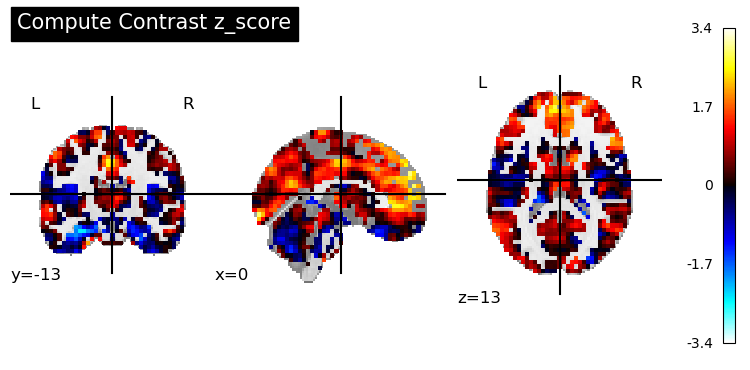

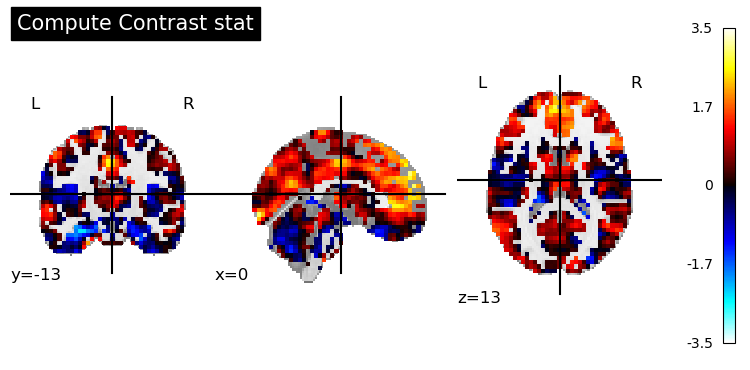

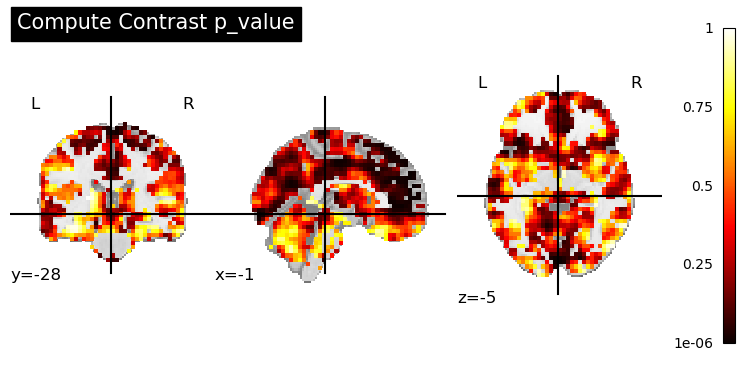

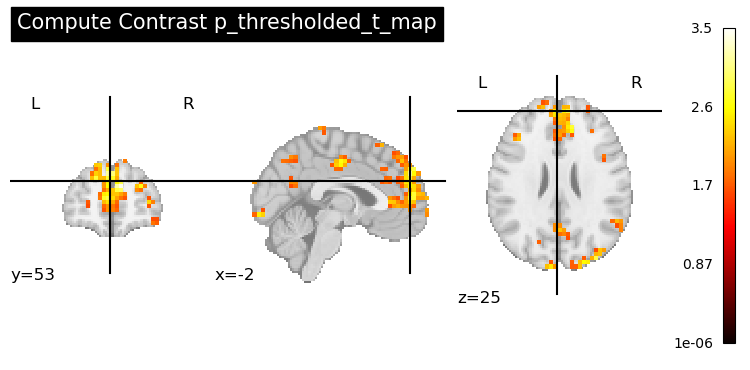

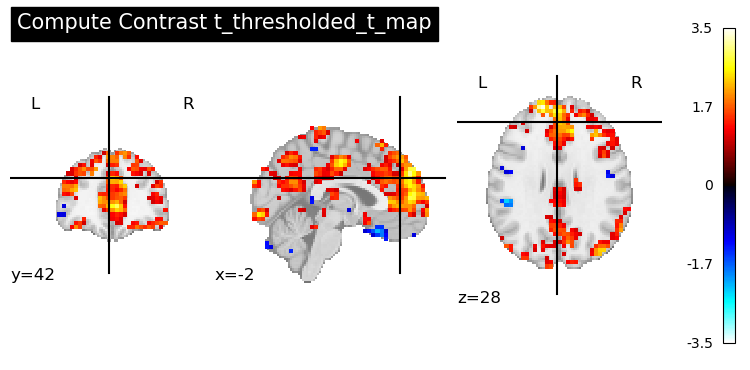

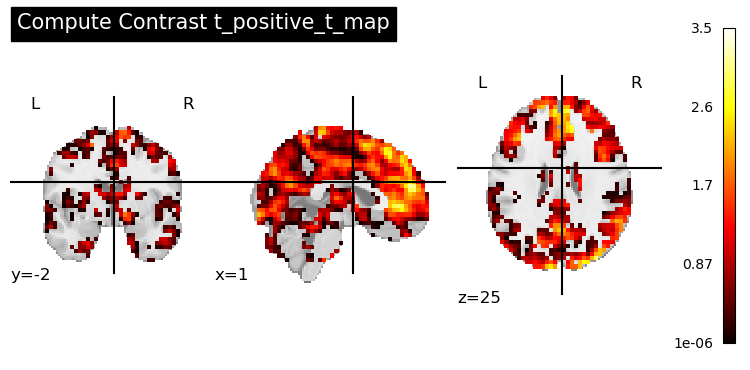

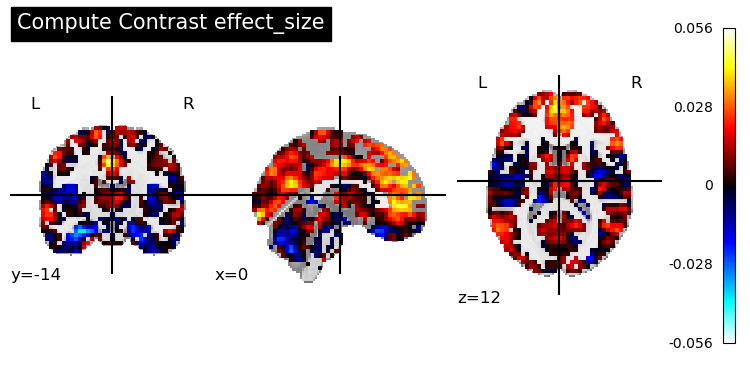

In [79]:
from scipy.stats import norm


plotting.plot_stat_map(
    comput_constrast_outputs["z_score"],
    title="Compute Contrast z_score",
)
plotting.plot_stat_map(
    comput_constrast_outputs["stat"],
    title="Compute Contrast stat",
)
plotting.plot_stat_map(
    comput_constrast_outputs["p_value"],
    cmap='hot',
    title="Compute Contrast p_value",
)
plotting.plot_stat_map(
    p_thresholded_t_map,
    cmap='hot',
    title="Compute Contrast p_thresholded_t_map",
)
plotting.plot_stat_map(
    t_thresholded_t_map,
    title="Compute Contrast t_thresholded_t_map",
)
plotting.plot_stat_map(
    t_positive_t_map,
    cmap='hot',
    title="Compute Contrast t_positive_t_map",
)
plotting.plot_stat_map(
    comput_constrast_outputs["effect_size"],
    title="Compute Contrast effect_size",
)

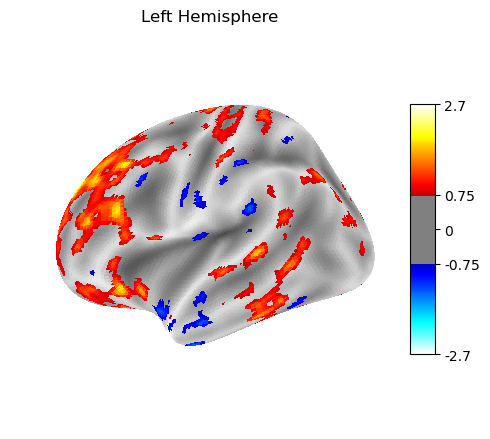

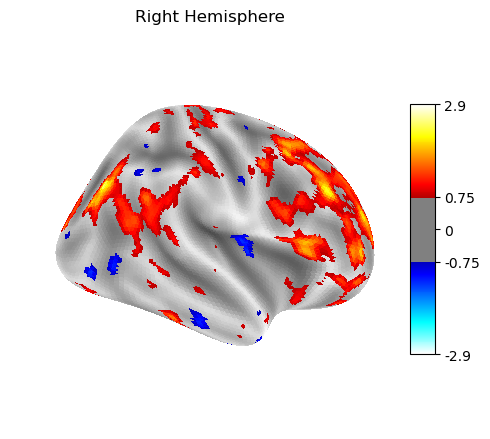

In [80]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()

# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere', 
    threshold=0.75, bg_map=fsaverage.sulc_left
)


plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere',
    threshold=0.75, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()

In [81]:
from nilearn import image, plotting
from nilearn.glm.second_level import non_parametric_inference
import numpy as np
# Set the cluster-forming threshold (voxel-level p-value)

# Number of permutations
n_perm = 10000
# Perform non-parametric inference with cluster-level correction
outputs = non_parametric_inference(
    second_level_input=z_maps,
    design_matrix=design_matrix,
    second_level_contrast=variable,
    n_perm=n_perm,
    two_sided_test=True,
    mask=None,
    smoothing_fwhm=None,
    n_jobs=-1,
    threshold=0.05,
    verbose=1,
)

Fitting second level model...
Computation of second level model done in 0.13135933876037598 seconds


In [22]:
from nilearn.reporting import get_clusters_table
from nilearn import image
import numpy as np
from scipy.stats import t
from nilearn.image import get_data

t_map = outputs["t"]
p_map = outputs["logp_max_t"]

from nilearn.image import math_img
from scipy.stats import t

# 자유도 설정 (예: 표본 수 - 모수 수)
df = 137 - 5  # 적절한 자유도로 변경하세요
p_threshold = 0.01
# p < 0.05에 해당하는 t-값 임계값 계산 (양측 검정)
t_threshold = t.ppf(1 - p_threshold / 2, df)

print("p < 0.05에 해당하는 t 임계값:", t_threshold)

# t-값의 절대값이 임계값보다 큰 보셀만 남기기 위한 마스크 생성
t_abs_thresholded_map = math_img('np.abs(img) > {}'.format(t_threshold), img=t_map)

# 원본 t_map에 마스크를 적용하여 t-값 임계값이 적용된 t_map 생성
t_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=t_abs_thresholded_map)

# p_map에서 p < 0.05인 보셀만 남기기 위한 마스크 생성
p_thresholded_map = math_img('img < {}'.format(p_threshold), img=p_map)

# 원본 t_map에 마스크를 적용하여 p-값 임계값이 적용된 t_map 생성
p_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=p_thresholded_map)

# Extract min and max values from p_thresholded_t_map and t_thresholded_t_map
p_thresholded_t_data = get_data(p_thresholded_t_map)
t_thresholded_t_data = get_data(t_thresholded_t_map)

# Calculate the min and max values
p_thresholded_t_min = np.min(p_thresholded_t_data)
p_thresholded_t_max = np.max(p_thresholded_t_data)
t_thresholded_t_min = np.min(t_thresholded_t_data)
t_thresholded_t_max = np.max(t_thresholded_t_data)

print("p_thresholded_t_map: min =", p_thresholded_t_min, "max =", p_thresholded_t_max)
print("t_thresholded_t_map: min =", t_thresholded_t_min, "max =", t_thresholded_t_max)

p < 0.05에 해당하는 t 임계값: 2.613588241960226
p_thresholded_t_map: min = -2.997029263601701 max = 2.583772377963105
t_thresholded_t_map: min = -5.7747997093361105 max = 3.003038559889188


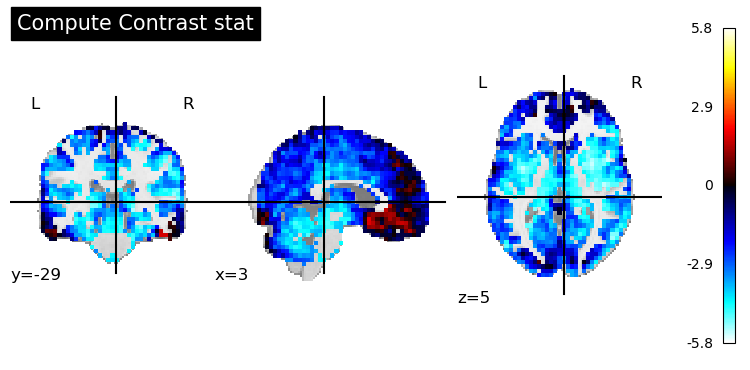

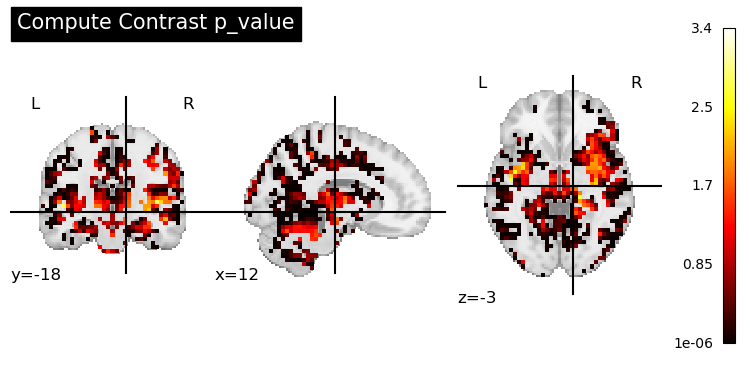

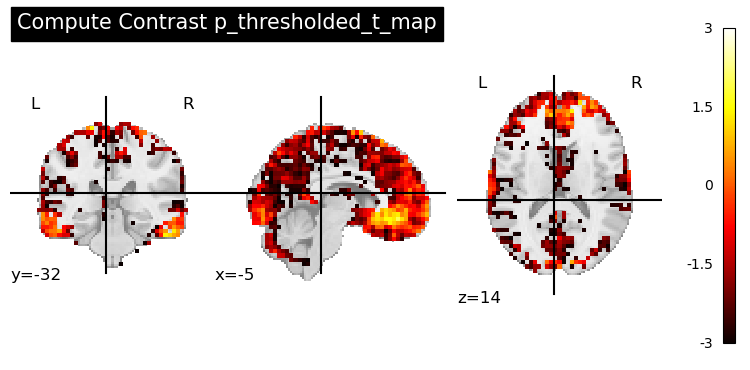

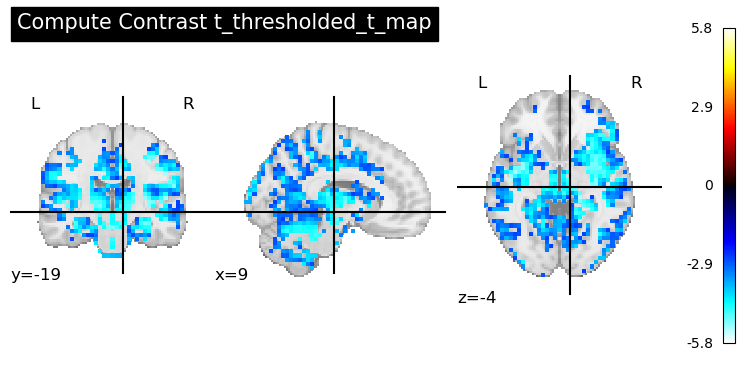

In [23]:
from scipy.stats import norm


plotting.plot_stat_map(
    outputs["t"],
    title="Compute Contrast stat",
)
plotting.plot_stat_map(
    outputs["logp_max_t"],
    cmap='hot',
    title="Compute Contrast p_value",
)
plotting.plot_stat_map(
    p_thresholded_t_map,
    cmap='hot',
    title="Compute Contrast p_thresholded_t_map",
)
plotting.plot_stat_map(
    t_thresholded_t_map,
    title="Compute Contrast t_thresholded_t_map",
)

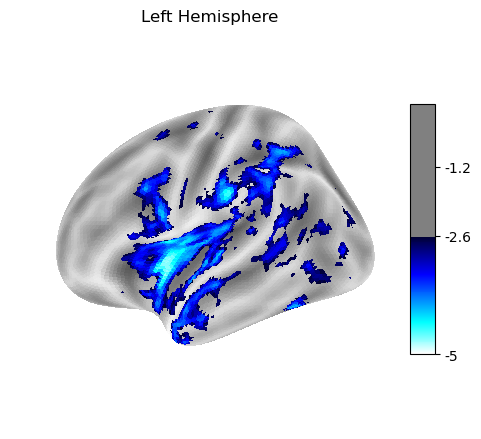

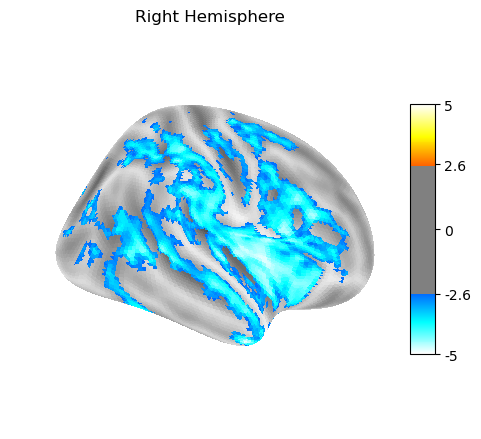

In [24]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()

# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_thresholded_t_map, fsaverage.pial_left)
texture_right = vol_to_surf(t_thresholded_t_map, fsaverage.pial_right)

# Plot the surface with the projected texture
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere', 
    threshold=t_threshold, bg_map=fsaverage.sulc_left
)

plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere',
    threshold=t_threshold, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()

In [ ]:
from nilearn.image import new_img_like
import scipy.stats as stats

# Load the data using outputs
t_data = outputs["t"].get_fdata()

# Calculate the 97.5% critical t-value (two-tailed)
# You need to provide the degrees of freedom (df) for your analysis
df = outputs["t"].shape[0] - 1  # Assuming df is number of samples - 1
t_cutoff = stats.t.ppf(0.975, df)

# Identify significant positive effects (t > cutoff)
positive_effects = t_data > t_cutoff

# Identify significant negative effects (t < -cutoff)
negative_effects = t_data < -t_cutoff

# Create images of positive and negative effects using nilearn
positive_effects_img = new_img_like(outputs["t"], positive_effects.astype(int))
negative_effects_img = new_img_like(outputs["t"], negative_effects.astype(int))

# Save or process these images further


/tmp/ipykernel_921134/1717427628.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  positive_effects_img = new_img_like(outputs["t"], positive_effects.astype(int))
/tmp/ipykernel_921134/1717427628.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  negative_effects_img = new_img_like(outputs["t"], negative_effects.astype(int))


In [122]:
from nilearn import plotting

# Visualize the unthresholded t-map
view = plotting.view_img(outputs["logp_max_t"], title="logp_max_t")

# Save the interactive HTML file
view.save_as_html("logp_max_t.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [123]:
from nilearn import plotting

# Visualize the unthresholded t-map
view = plotting.view_img(outputs["t"], title="t")

# Save the interactive HTML file
view.save_as_html("t.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [124]:
from nilearn import image, plotting
import numpy as np

# Define the threshold value for p < 0.05 in log10 scale
p_threshold_log = -np.log10(0.05)

# Apply the threshold to the logp_max_t map
thresholded_logp_max_t = image.threshold_img(outputs["logp_max_t"], threshold=p_threshold_log)

# Use the thresholded logp_max_t to mask the corresponding t-map
thresholded_t_map = image.math_img("img1 * (img2 > {})".format(p_threshold_log), 
                                   img1=outputs["t"], img2=outputs["logp_max_t"])

# Visualize the thresholded t-map
view = plotting.view_img(thresholded_t_map, title="Thresholded t-map (p < 0.05)")

# Save the interactive HTML file
view.save_as_html("thresholded_t_map_p_0_05.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [125]:
from nilearn import plotting
import numpy as np

# Load the t and log(p) data
t_img = outputs["t"]
p_img = outputs["logp_max_t"]
p_data = p_img.get_fdata()

# Define the significance threshold (p < 0.05)
significance_threshold = -np.log10(0.05)

# Mask where the p-value is significant (p < 0.05)
significant_mask = p_data > significance_threshold

# Apply the mask to the t-map (setting non-significant areas to 0)
t_data = t_img.get_fdata()
thresholded_t_data = np.where(significant_mask, t_data, 0)

# Create a new image for the thresholded t-map
thresholded_t_img = new_img_like(t_img, thresholded_t_data)

# Visualize the thresholded t-map
view = plotting.view_img(thresholded_t_img, title="Thresholded T-Map (p < 0.05)")

# Save the interactive HTML file
view.save_as_html("thresholded_t_map_p0.05.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


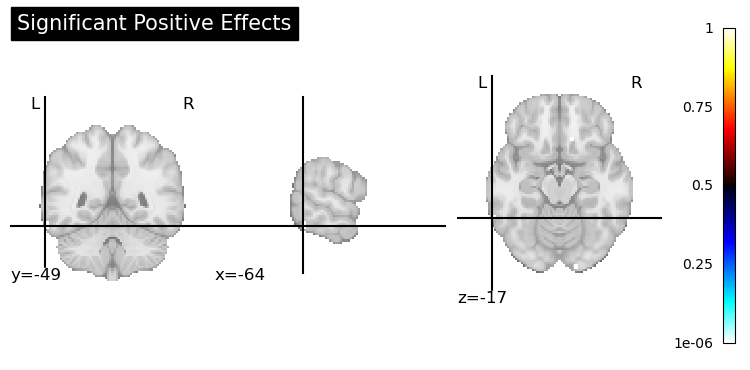

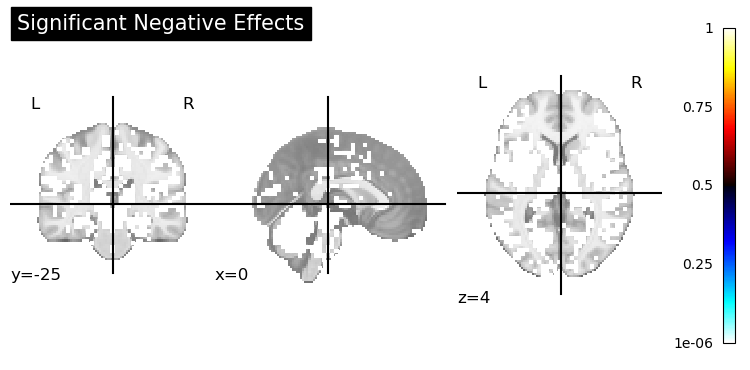

In [ ]:
from nilearn import plotting

# Plot positive effects
plotting.plot_stat_map(
    positive_effects_img,
    title='Significant Positive Effects',
    display_mode='ortho',
    colorbar=True,
)

# Plot negative effects
plotting.plot_stat_map(
    negative_effects_img,
    title='Significant Negative Effects',
    display_mode='ortho',
    colorbar=True,
)

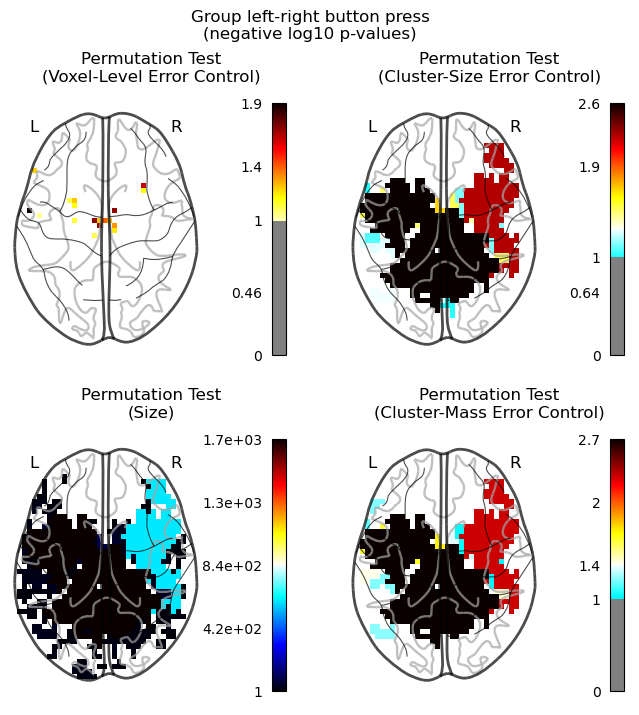

In [ ]:
import itertools
import matplotlib.pyplot as plt

threshold = 1  # p < 0.1
vmax = 2.69  # ~= -np.log10(1 / 500)

cut_coords = [0]

IMAGES = [
    outputs["logp_max_t"],
    outputs["logp_max_size"],
    outputs["size"],
    outputs["logp_max_mass"],
]
TITLES = [
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Size)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        display_mode="z",
        plot_abs=False,
        cut_coords=cut_coords,
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("Group left-right button press\n(negative log10 p-values)")
plt.show()


In [8]:
p_map = second_level_model.compute_contrast(variable,output_type="p_value")
t_map = second_level_model.compute_contrast(variable, output_type="stat")



In [9]:
from nilearn import image
import numpy as np

# p-value 맵에서 0.05 이하인 부분만 마스크 생성
mask_img = image.math_img('img < 0.05', img=p_map)

# 마스크를 적용하여 t-statistic 맵 필터링
masked_t_map = image.math_img('img1 * img2', img1=t_map, img2=mask_img)

t_data = image.get_data(masked_t_map)
t_min = np.min(t_data[t_data != 0])  # 0이 아닌 값 중 최소값
t_max = np.max(t_data)

print(f"Minimum t-value (excluding zeros): {t_min}")
print(f"Maximum t-value: {t_max}")
masked_t_map.to_filename(f"{group}_{variable}_{roi}_tmap.nii.gz")

Minimum t-value (excluding zeros): 1.6863147795769546
Maximum t-value: 2.787528827809305


In [22]:
from nilearn.reporting import get_clusters_table
table, label_maps = get_clusters_table(t_map, stat_threshold=1.68, cluster_threshold=5, return_label_maps=True)
table.set_index("Cluster ID", drop=True)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-64.375,-49.625,-19.0,2.787529,320
1,2,11.625,34.375,-19.0,2.696145,576
2,2a,7.625,26.375,-19.0,2.565766,
3,3,-0.375,26.375,-7.0,2.409346,320


In [24]:
label_maps[0].to_filename(f"{group}_{variable}_{roi}_cluster_label.nii.gz")

In [66]:
from nilearn.glm.second_level import non_parametric_inference


out_dict = non_parametric_inference(
    z_maps,
    design_matrix=design_matrix,
    second_level_contrast=variable,
    n_perm=15000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    n_jobs=-1,
    verbose=1,
)

Fitting second level model...
Computation of second level model done in 0.13392424583435059 seconds


In [67]:
neg_log10_vfwe_pvals_img = out_dict
neg_log10_vfwe_pvals_img.to_filename(f"{group}_{variable}_{roi}_voxel_not_thresholded.nii.gz")

In [35]:
p_cut_off = 0.05
voxel_p_value_cutoff = -np.log10(p_cut_off)
mask_img = image.math_img(f'img > {voxel_p_value_cutoff}', img=neg_log10_vfwe_pvals_img)
masked_p_map = image.math_img('img1 * img2', img1=neg_log10_vfwe_pvals_img, img2=mask_img)
masked_p_map.to_filename(f"{group}_{variable}_voxel_{p_cut_off}.nii.gz")
logp_max_size = out_dict["logp_max_size"]
logp_max_t = out_dict["logp_max_t"]
cluster_cut_off = 0.05
p_cut_off = 0.005
cluster_p_value_cutoff = -np.log10(cluster_cut_off)  # p-value 0.05에 해당하는 -log10 값
voxel_p_value_cutoff = -np.log10(p_cut_off)
mask_img = image.math_img(f'img > {cluster_p_value_cutoff}', img=logp_max_size)
mask_img2 = image.math_img(f'img > {voxel_p_value_cutoff}', img=logp_max_t)
masked_p_map = image.math_img('img1 * img2', img1=mask_img, img2=mask_img2)
masked_p_map.to_filename(f"voxel_{p_cut_off}_cluster_{cluster_cut_off}_cutoff.nii.gz")